STEP 1: Install Required Packages

In [2]:
!pip install DeepFace

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=3b315380c98a686977f3db61bfee2b22739b2c744e826eca723b912bd0c4c903
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


STEP 2: Import Libraries

In [3]:
import os
import numpy as np
from deepface import DeepFace
import shutil
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


25-06-23 13:12:11 - Directory /root/.deepface has been created
25-06-23 13:12:11 - Directory /root/.deepface/weights has been created




**STEP 3: Mount Google Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**STEP 4: Set Paths**

In [22]:
# Input and output directories
image_folder = "/content/drive/MyDrive/new"  # Folder containing all shared images
output_base = "/content/drive/MyDrive/SoWW"     # Folder for clustered faces
invalid_folder = "/content/drive/MyDrive/SoWW/Invalid_Faces"  # Folder for undetectable/blurry faces

# Ensure output directories exist
os.makedirs(output_base, exist_ok=True)
os.makedirs(invalid_folder, exist_ok=True)


**STEP 5: Load and Filter Image Files**

In [8]:
image_paths = [os.path.join(image_folder, f)
               for f in os.listdir(image_folder)
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]


**STEP 6: Extract Face Embeddings with Preprocessing**

In [9]:
embeddings = []
valid_image_paths = []

for path in image_paths:
    try:
        # Extract face embedding
        reps = DeepFace.represent(
            img_path=path,
            model_name='Facenet512',
            detector_backend='retinaface',
            enforce_detection=True
        )

        if len(reps) > 0:
            embeddings.append(reps[0]['embedding'])
            valid_image_paths.append(path)
        else:
            shutil.copy(path, invalid_folder)

    except Exception as e:
        print(f"Face not detected in: {path} — Moving to 'Invalid_Faces'")
        shutil.copy(path, invalid_folder)


25-06-23 13:14:22 - facenet512_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /root/.deepface/weights/facenet512_weights.h5
100%|██████████| 95.0M/95.0M [00:02<00:00, 34.2MB/s]


25-06-23 13:14:34 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:01<00:00, 72.0MB/s]


**STEP 7: Preprocess Embeddings - Normalize**

In [10]:
X = np.array(embeddings)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


**STEP 8: Dimensionality Reduction with PCA (retain 90% variance)**

In [11]:
pca = PCA(n_components=0.90)
X_pca = pca.fit_transform(X_scaled)


**STEP 9: Find Optimal Clusters (Elbow Method)**

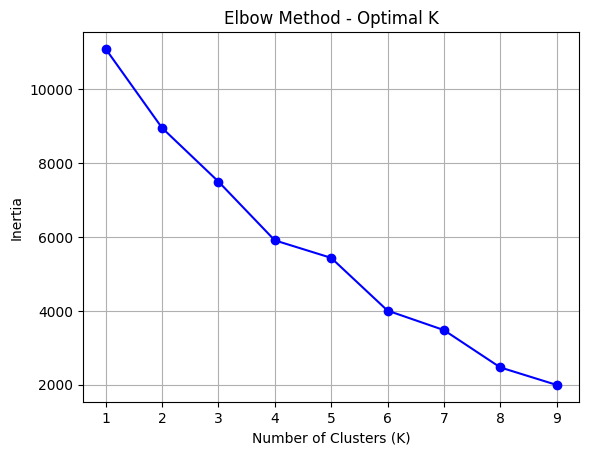

In [12]:
inertias = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)

plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method - Optimal K')
plt.grid(True)
plt.show()


**STEP 10: KMeans Clustering (Set K based on elbow curve)**

In [19]:
K = 6  # Change this based on Elbow plot
kmeans = KMeans(n_clusters=K, random_state=42)
labels = kmeans.fit_predict(X_pca)


**STEP 11: Organize Images into Cluster Folders**

In [20]:
for path, label in zip(valid_image_paths, labels):
    folder_name = f"Person_{label}"
    dest_folder = os.path.join(output_base, folder_name)
    os.makedirs(dest_folder, exist_ok=True)

    try:
        shutil.copy(path, dest_folder)
    except Exception as e:
        print(f"Error copying {path}: {e}")


**STEP 12: Optional Visualization of Clusters**


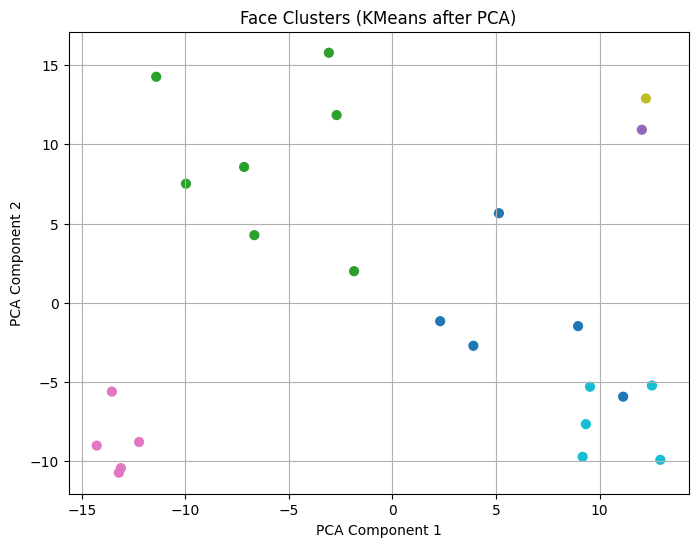

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=40)
plt.title("Face Clusters (KMeans after PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()
